## Number of synapses per connection

In this notebook you will analyze and validate one of parameter of the connectome: the number of synapses per connection.

Cell A is connected to cell B if the axon of one cell makes at least one synapse on the other cell (we do not consider gap junction).

A connection has a direction, so between A and B we can identify two pathways. A->B means that axon from A creates the synapse(s) on B, while B->A means that axon from B creates the synapse(s) on A.

Another important point is that a connection may have one or multiple synapses, which has an impact on the anatomy and physiology of the network.

In this notebook, you will analyze the number of synapses per connection in all the possible pathways.

---

Import some python packages.

In [1]:
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn

from bluepysnap import Circuit
from bluepysnap.bbp import Cell

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Reading and preparing the data.

In [2]:
circuit_path = '/home/data-bbp/20191017/circuit_config.json'
circuit = Circuit(circuit_path)
cells = circuit.nodes["hippocampus_neurons"]
conn = circuit.edges["hippocampus_neurons__hippocampus_neurons__chemical"]

Initialize where to store the results.

Since all the possible pathways form a 2D matrix, it is convenient to have one matrix where to store means and another one where to store standard deviations.

Furthermore, you are going to compare the result with values extracted from literature. Among those values, you have the number of synapses per connection in parvalbumin positive (PV+) cells, a group that includes SP_PVBC, SP_BS, and SP_AA. The group PV is already defined in the circuit, but you have to include it in the matrices.

In [3]:
mtypes = cells.property_values(Cell.MTYPE)
model_mean = pd.DataFrame(index=mtypes, columns=mtypes.union({u'PV'}), dtype=float)
model_std = pd.DataFrame(index=mtypes, columns=mtypes.union({u'PV'}), dtype=float)

The analysis could be quite expensive, so better to reduce the number of samples.

Furthermore, since you will repeat the same analysis many times, it is convenient to create a helper function.

In [4]:
nsample = 100
def sample_nsyn(pre, post):
    it = conn.iter_connections(pre, post, return_edge_count=True)
    return np.array([p[2] for p in itertools.islice(it, nsample)])

Here, you run the analysis.

Note that the function sample_nsyn returns a 2D matrix with all the same connections for a given pathway.

From this matrix, you will calculate the mean and standard deviation that end up in the result matrices. The current position in the analysis loop is indicated by the processed m-type. 

In [5]:
for pre_mtype in mtypes:
    for post_mtype in mtypes:
        data = sample_nsyn(
            pre={Cell.MTYPE: pre_mtype, Cell.REGION: {'$regex': 'mc2.*'}},
            post={Cell.MTYPE: post_mtype}
        )
        if len(data) != 0:
            model_mean[post_mtype][pre_mtype] = data.mean()
            model_std[post_mtype][pre_mtype] = data.std()
    print(pre_mtype)

SP_PC
SP_CCKBC
SR_SCA
SO_Tri
SP_AA
SP_Ivy
SO_BS
SO_BP
SP_BS
SLM_PPA
SP_PVBC
SO_OLM


In [6]:
model_mean

,SP_PC,SP_CCKBC,SR_SCA,SO_Tri,SP_AA,SP_Ivy,SO_BS,SO_BP,SP_BS,SLM_PPA,PV,SP_PVBC,SO_OLM
SP_PC,1.28,3.020000,2.610000,4.030000,3.770000,3.660000,6.330000,2.580000,3.350000,NaN,NaN,5.250000,2.810000
SP_CCKBC,8.64,1.400000,1.285714,3.073171,1.712644,3.210000,1.750000,2.666667,4.780000,NaN,NaN,4.160000,1.272727
SR_SCA,5.25,1.142857,4.200000,1.000000,1.090909,1.258427,1.636364,1.000000,1.304348,NaN,NaN,1.436782,1.111111
SO_Tri,6.83,1.348485,1.470588,3.050000,2.000000,2.940000,3.000000,2.000000,3.173913,NaN,NaN,3.510000,3.000000
SP_AA,7.24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SP_Ivy,14.37,2.670000,2.833333,3.470000,3.140000,4.700000,1.368421,1.275000,5.830000,1.0,NaN,6.130000,1.246154
SO_BS,6.50,1.541667,1.833333,1.333333,1.545455,2.486111,NaN,1.500000,2.312500,NaN,NaN,3.204545,1.600000
SO_BP,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SP_BS,5.99,1.800000,2.210526,2.655172,2.870968,3.880000,2.153846,2.222222,4.246753,NaN,NaN,4.240000,1.603774
SLM_PPA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Plot the result using an heatmap.

Note that when you have a white cell, it means that the two cell types are not connected (at least in the sample tested).

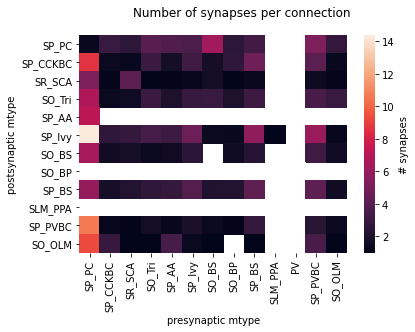

In [7]:
ax = seaborn.heatmap(model_mean)

fig = plt.gcf()
fig.suptitle('Number of synapses per connection', )

ax.set_xlabel('presynaptic mtype')
ax.set_ylabel('postsynaptic mtype')

ax.collections[0].colorbar.set_label("# synapses")

fig.show()

After having analyzing the circuit, you can compare the model with experimental data extracted from literature.

The next cell loads the experimental data and puts it in a pandas dataframe.

In [8]:
bio_path = '/home/data-bbp/20191017/bioname/nsyn_per_connection_20190131.tsv'

In [9]:
df = pd.read_csv(bio_path, skiprows=1, names=['pre', 'post', 'bio_mean', 'bio_std'], usecols=[0, 1, 2, 3], delim_whitespace=True)
df.head()

,pre,post,bio_mean,bio_std
0,SP_BS,SP_PC,6.000000,0.000000
1,SP_PVBC,PV,1.546875,1.083182
2,SP_PC,SO_OLM,2.800000,0.800000
3,SO_OLM,SP_PC,10.000000,7.000000
4,SP_AA,SP_PC,6.100000,NaN


As you can see, there are only a limited number of pathways.

Extract from the result matrices only the pathways for which you have experimental data.

In [10]:
df['mod_mean'] = np.NAN
df['mod_std'] = np.NAN

In [11]:
for idx in df.index:
    pre = df.loc[idx, 'pre']
    post = df.loc[idx, 'post']
    df.loc[idx, 'mod_mean'] = model_mean[post][pre]
    df.loc[idx, 'mod_std'] = model_std[post][pre]

Now we plot the results. The more points are lying on the diagonal, the more the model is close to experimental values.

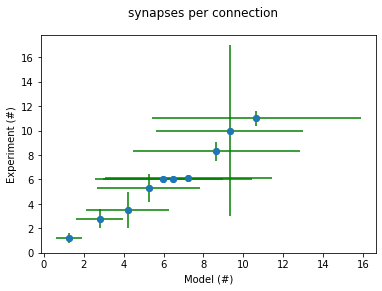

In [12]:
plt.clf
x = df['mod_mean'].values
y = df['bio_mean'].values
l = np.linspace(0, max(x.max(), y.max()), 50)
fig, ax = plt.subplots()
fig.suptitle('synapses per connection')
ax.plot(x, y, 'o')
ax.errorbar(x, y, xerr=df['mod_std'].values, yerr=df['bio_std'].values, fmt='o', ecolor='g', capthick=2)
ax.plot(l, l, 'k--')
ax.set_xlabel('Model (#)')
ax.set_ylabel('Experiment (#)')

fig.show()

### Exercise #1
Calculate the average number of synapses per connection in the four classes of connections (EE, EI, IE, II). Put the answer in a list called ans_1. Respect the order (EE, EI, IE, II).

### Exercise #2
Calculate the distribution of number of synapses from SP_PVBC to SP_PC. Put the answer in a list named ans_2 with mean and std

In [ ]:
# Work here

In [ ]:
# This is to generate the answers to paste in the submission box below.
# Run this and copy-paste the output into the box below
print(json.dumps(dict([("ans_1", ans_1),
                       ("ans_2", ans_2)])))

In [ ]:
!pip -q install -i https://bbpteam.epfl.ch/repository/devpi/simple/ single-cell-mooc-client==0.0.5 
import single_cell_mooc_client as sc_mc
s = sc_mc.Submission(hideToken=True)

In [ ]:
s.show_submission(ROLLBACK, TOKEN)